# Data Set Exploration

## Approach
In this notebook, I take a first look at the data to understand its size, attributes and structure. I structure each step in the analysis under a new heading. At the start of a block, I sometimes denote my initial thoughts and what I am looking for before I do the analysis. At the end of each block, I summarize my observations and assumptions. 

## Imports

In [25]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import altair as alt
import os
import warnings
from challenge_helpers import helpers #local module that contains larger code blocks to keep things simple here
warnings.filterwarnings('ignore')

In [2]:
REPO = Path(os.getcwd()) / ".."
DATA = REPO / "data" / "sample_temperature_data_for_coding_challenge.csv"

## Read Data, look at shape of data

In [3]:
ts = pd.read_csv(DATA)
ts.datetime = pd.to_datetime(ts.datetime)

In [4]:
ts.head()

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13 17:51:16+00:00,heating_temperature,33.3
1,MICDEV001,2019-04-13 17:51:16+00:00,cooling_temperature,15.0
2,MICDEV001,2019-04-13 18:51:18+00:00,heating_temperature,34.0
3,MICDEV001,2019-04-13 19:51:20+00:00,heating_temperature,33.8
4,MICDEV001,2019-04-13 20:51:21+00:00,heating_temperature,34.2


In [5]:
len(ts)

1000

In [6]:
ts.isna().sum()

source_id        0
datetime         0
property_name    0
temperature      0
dtype: int64

**Observations:**
1. The dataset has 5 columns that I will look into in more detail in the next exploration step
2. The dataset is relatively small with just 1000 rows
3. The dataset does not have null values.

## Looking at individual columns

### source_id

In [7]:
ts.source_id.value_counts()

source_id
MICDEV001    1000
Name: count, dtype: int64

**Observation:** column `source_id` has only one value, which is why I will not further investigate this column. "MICDEV001" is probably the identifier of some device that produced the time series. 

In [8]:
ts = ts.drop("source_id", axis=1)

### property_name

In [9]:
ts.property_name.value_counts()

property_name
heating_temperature    699
cooling_temperature    301
Name: count, dtype: int64

**Observation**: The column `property_name` has two values. My initial thoughts are that their function could be one of the following:
1.  It could be the identifier of two separate time series
2. It could identify specific events within a single time series

I expect that the examination of the time stamps will bring more clarity here.

### temperature

**Initial thoughts:** The column temperature is the only numerical column in the dataset and therefore outliers will have to be detected here. As I don't know yet, whether `property_name` describes two timeseries or events along a single timeseries, I am going to plot both options in a boxplot to see, whether any outliers are visible right away.

<Axes: >

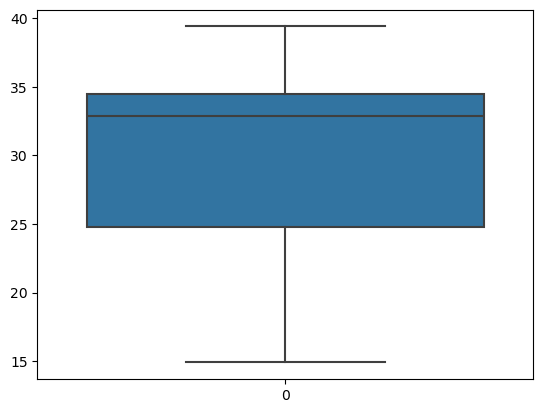

In [10]:
sns.boxplot(ts.temperature)

<Axes: xlabel='property_name', ylabel='temperature'>

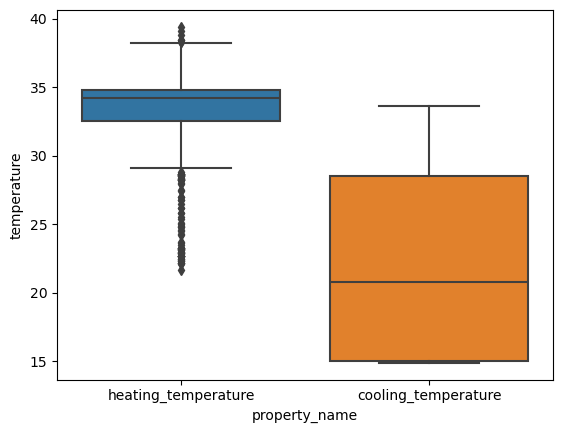

In [11]:
sns.boxplot(ts, y="temperature", x="property_name")

**Observations:**
1. The first boxplot shows that the temperatures provided are all within a range that does not point to obvious errors within the data. Neither 0-values, negative values nor extremely large values are present.
2. The second boxplot shows differences in the distribution of heating_temperatures and cooling_temperatures. Also `heating_temperatures` seem to have values that depart further from the mean whereas `cooling_temperatures` appears to be skewed towards 15. I want to learn more about the distributions of these variables, especially whether any dominant values are present. Therefore, I am going to plot the distributions in separate histograms.

<Axes: xlabel='temperature', ylabel='Count'>

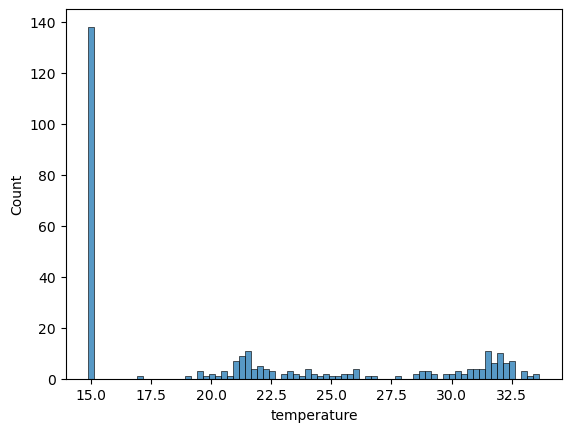

In [12]:
sns.histplot(ts[lambda x: x.property_name == "cooling_temperature"], x="temperature", binwidth=0.25)

<Axes: xlabel='temperature', ylabel='Count'>

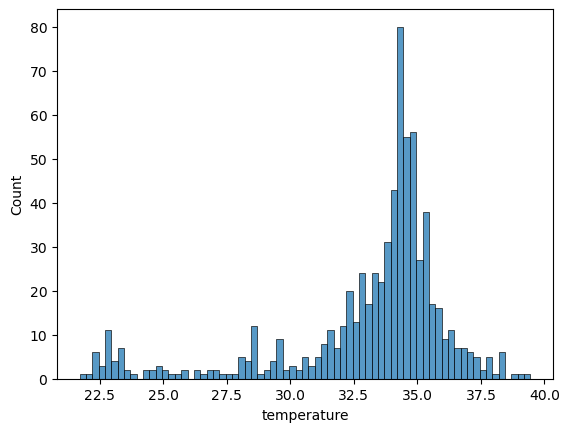

In [13]:
sns.histplot(ts[lambda x: x.property_name == "heating_temperature"], x="temperature", binwidth=0.25)

**Observations:**
1. For the case of `cooling_temperature`apparently about a majority of all values reside at about 15. I cannot decide, if this hints at a data quality issue without more background on the origin of the data. 
2. For the case of `heating_temperature` the data seems to be distributed around the mode at about 34. Cutoffs or thresholds are not apparent.

## datetime

This is where things get interesting now. I divide the exploration into two steps: First, I'd like to examine the datetime property alone and see, whether there are gaps in the data and explore the frequency of timestamps. Then, I am going to look at datetime and temperature in combination to see, if there are patterns in the temperature readings over time and whether there are already deviations from those patterns that should be covered by an anomaly detection algorihm.

### Exploring datetime on its own: Range, resolution and sparsity
**Initial Thoughts:** I'd like to identify the following properties of the time series:   
1. **range**: Which date range is covered by the timeseries
1.  **resolution**: Is this a regular time series where timestamps are recorded in a fixed time interval? If so, how large are the intervals
1. **sparsity / completeness:** Is the timeseries complete, meaning there is a record for every interval step possible in the covered time range? If there are gaps, how large are those?


#### Range

In [14]:
ts.datetime.max()-ts.datetime.min()

Timedelta('285 days 15:05:20')

**Observation:** The timeframe covered is less than a year. The amount of timestams provided (1000) could hint that the series has a resolution of days or hours. I will therefore look at the sorted range and see, if any resolution is apparent right away:

#### Resolution

In [15]:
ts.sort_values(axis=0, by="datetime").head(20)

,datetime,property_name,temperature
0,2019-04-13 17:51:16+00:00,heating_temperature,33.3
1,2019-04-13 17:51:16+00:00,cooling_temperature,15.0
2,2019-04-13 18:51:18+00:00,heating_temperature,34.0
3,2019-04-13 19:51:20+00:00,heating_temperature,33.8
4,2019-04-13 20:51:21+00:00,heating_temperature,34.2
5,2019-04-13 21:51:23+00:00,heating_temperature,34.5
6,2019-04-13 22:51:25+00:00,heating_temperature,34.7
7,2019-04-13 23:51:26+00:00,heating_temperature,34.8
8,2019-04-14 00:51:28+00:00,heating_temperature,34.9
9,2019-04-14 01:51:30+00:00,heating_temperature,35.0


**Observation:**
1. Datetimestamps seem to be recorded on an hourly basis. However, they do not seem to be recorded at exactly the same moment in time within an hour, which hints that the process of recording data is started and stopped manually multiple times. I am therefore going to investigate, whether the data can be resampled to an hourly resolution.
2. Timestamps for `heating_temperature` and `cooling_temperature`seem to be recorded at exactly the same points in time. This leads me to the conclusion that these are separate timeseries and not events along the same timeseries, and I will treat them as such in the following.

#### Sparsity

**Initial Thouhts** Based on the observations above, I would like to find out if there are recordings for each day in the covered timerange or if there are sub-periods for which data is recorded. To that end, I am going to resample the timeseries to single days and plot these in histograms.

In [16]:
ts["date_"] = ts.datetime.dt.date

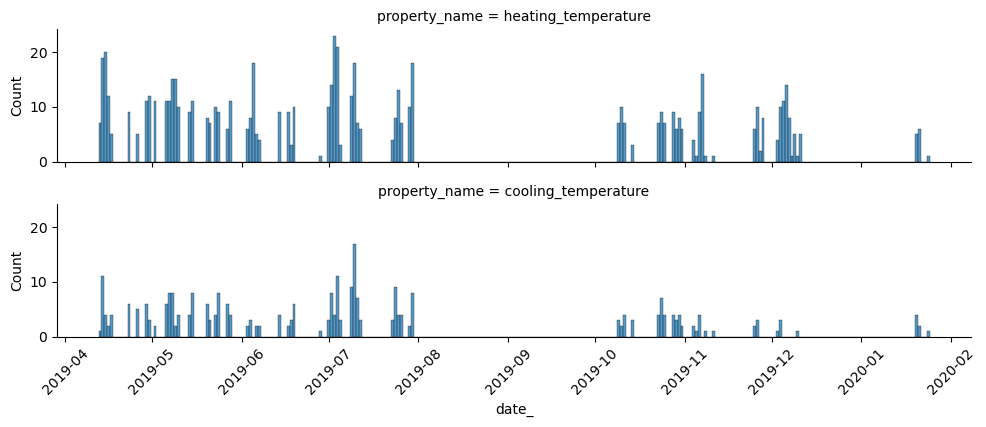

In [17]:
helpers.generate_facet_plot_histogram(ts, x="date_", row="property_name", height=2, aspect=5)

**Observations:** 
1. There are quite large gaps during the summer months and in winter. These could hint that the data originates from a production process that pauses during summer and christmas.
2. There seem to be reoccurring blocks of recordings on a weekly basis with pauses in between which could represent weekends, allthough within these blocks, data also seems to be missing for some workdays. These could be public holidays or simply production stops.

I am going to layer the data based on hour of the day to see, if similar patterns are apparent.

In [18]:
ts["hour"] = ts.datetime.dt.hour

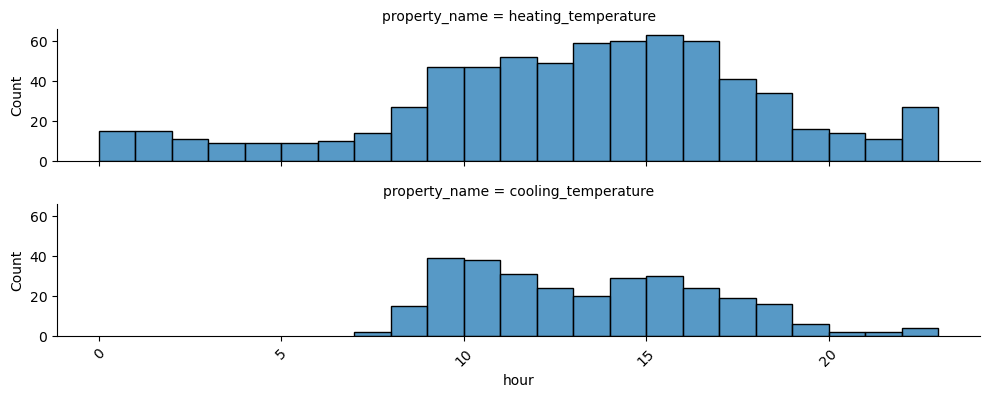

In [24]:
helpers.generate_facet_plot_histogram(ts, x="hour", row="property_name", height=2, aspect=5)

**Observation:** 

Frequency counts on an hourly basis seem to indicate that more recordings are made during working hours throughout the day, allthough there are also some recordings at nightimes. Apart from that, these histograms do not allow any obvious conclusions.

### Looking at patterns in temperature readings over time
**Initial thoughts:** Based on the findings of the previous section, I would like to investigate, if there are *daily patterns:* Are there any recurring patterns in temperature readings on a daily basis? Therefore, I am going to slice the data by day and layer them on top of each other in line charts.

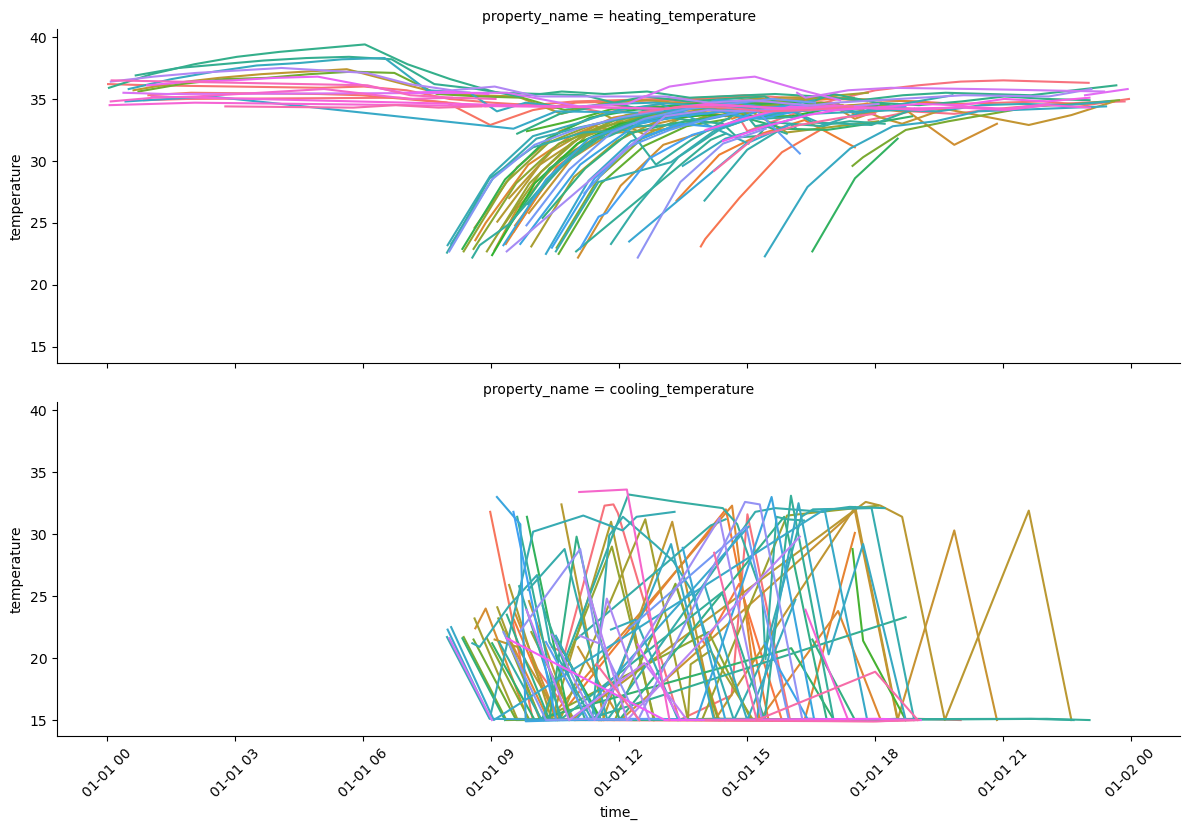

In [20]:
ts["time_"] = pd.to_datetime("1999-01-01 " + ts.datetime.dt.time.astype(str))
helpers.generate_facet_plot_line(ts, x="time_", y="temperature", hue="date_", row="property_name", height=4, aspect=3)

**Observations:** 

Apparently for the case of `heating_temperature`, there are at least two prominent daily patterns: 

1. *increasing pattern:* Temperature curves start to increase from about 24 and increase until they reach about 35. These patterns start mostly during early working hours and sometimes also later in the day. This is considered a normal pattern.
2. *constant pattern*: The other prominent pattern are temperature curves that are more or less flat throughout the day. Probably, because production processes have been started the day before and temperatures did not drop since. This is considered an abnormal pattern.

For the case of `cooling_temperature`, patterns cannot be identified that easily. Therefore, I want to improve the chart above by the following:
1. *resampling:* I am going to resample the data so that the data is evenly spaced. For hours that have more than one temperature reading per hour recorded, I will take the mean.
1. *Null-Values:* NULL/NaN Values lie between two data points that result because there was no temperature reading in a certain hour should result in a break in the lines. The plotting library that I use above does not allow to do that easily. I therefore use a different one below.
2. *weekly splits*:  I want to see, if pattern 2 described above directly connects to curves that show temperature increases the day before. Therefore, I am going to split the timeseries by weeks instead of days.

In [21]:
resampled_ts = (
    ts
    .pipe(helpers.extract_week_number)
    .pipe(helpers.normalize_to_start_of_week)
    .pipe(helpers.resample_to_hours)
    )

**NOTE:** The chart below looks messy but it is interactive. I navigate through the timeseries by clicking on the icons in the legend to the right of the main chart. This enables me to view individual data points in context of the other data.

In [22]:
helpers.generate_weekly_line_plot(resampled_ts)

alt.HConcatChart(...)

**Observations**
1. Gaps in the data within one day: From several of the time series above, it becomes visible that data within each day is not complete meaning there are missing temperature readings for certain hours. This may indicate that there is a change in the production process that generates the data such as heating or cooling is temporarily turned off.